# Análisis y dimensionamiento de OTA 5T

En base al uso de tablas precomputadas, en este notebook se detalla el proceso de análisis de un circuito, su dimensionamiento y la obtención de especificaciones aproximadas con ecuaciones analíticas.

## Dependencies

In [1]:
# System
from pathlib import Path
from copy import deepcopy
from pprint import pprint
from typing import TypeAlias
from IPython.display import display

# Python Analysis
import matplotlib.pyplot as plt
from matplotlib.axis import Axis
import numpy as np
import pandas as pd

# IC Analysis
from pygmid import Lookup as lk
import scipy.constants as sc
from scipy.constants import Boltzmann as kB

# Aliases
Fets: TypeAlias = dict[str, dict[str, float | int | lk]]
System: TypeAlias = dict[str, float | int]

mat_folder = Path("../../../simulations")

nfet_mat = mat_folder / "nfet_01v8.mat"
pfet_mat = mat_folder / "pfet_01v8.mat"
nfet_lvt_mat = mat_folder / "nfet_01v8_lvt.mat"
pfet_lvt_mat = mat_folder / "pfet_01v8_lvt.mat"

if not nfet_mat.exists():
    raise ValueError(f"MAT file {nfet_mat} doesn't exists")
if not nfet_lvt_mat.exists():
    raise ValueError(f"MAT file {nfet_lvt_mat} doesn't exists")
if not pfet_mat.exists():
    raise ValueError(f"MAT file {pfet_mat} doesn't exists")
if not pfet_lvt_mat.exists():
    raise ValueError(f"MAT file {pfet_lvt_mat} doesn't exists")

nfet = lk(filename=str(nfet_mat))
nfet_lvt = lk(filename=str(nfet_lvt_mat))
pfet = lk(filename=str(pfet_mat))
pfet_lvt = lk(filename=str(pfet_lvt_mat))

## Análisis y Diseño de Circuitos Integrados

### Estrategia de Dimensionamiento de Fets

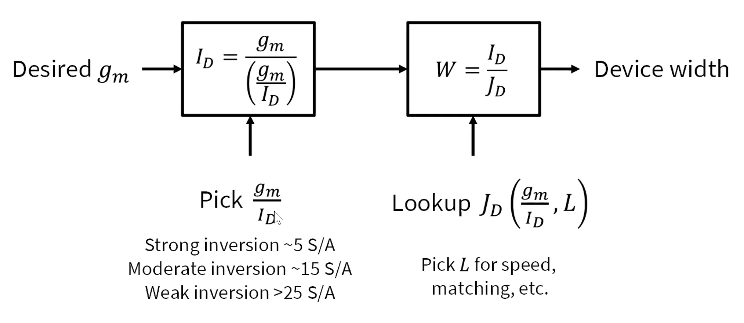

Cuando se puede derivar que transconductancia $g_m$ necesita un transistor, basta estimar cuanta eficiencia $g_m/I_D$ y el largo $L$ para obtener el resto de parámetros de interés, digase el ancho $W$, frecuencias de tránsito $f_T$, etc.

La información obtenida en esta etapa se respalda en datos obtenidos por medio de simulaciones, lo que evita el uso de modelos que pueden ser imprecisos.

### Especificaciones Técnicas

Una solicitud realista de un diseño puede ser como sigue:

- Un buffer amplificador
- El ruido debe estar bajo 50 uV_rms del total de ruido integrado de salida
- La ganancia en loop al menos de 30
- Entrada cercana a 0.9V
- Buffer nunca debe oscilar, PM de 80
- Obten máximo ancho de banda, se dispone de potencia

Este es solo un subconjunto de especificaciones técnicas en alto nivel.
Un diseñador de circuitos tiene que colectar las especificaciones, cuales otras existen y sean relevantes para la aplicación del circuito.

### Fases del flujo de diseño

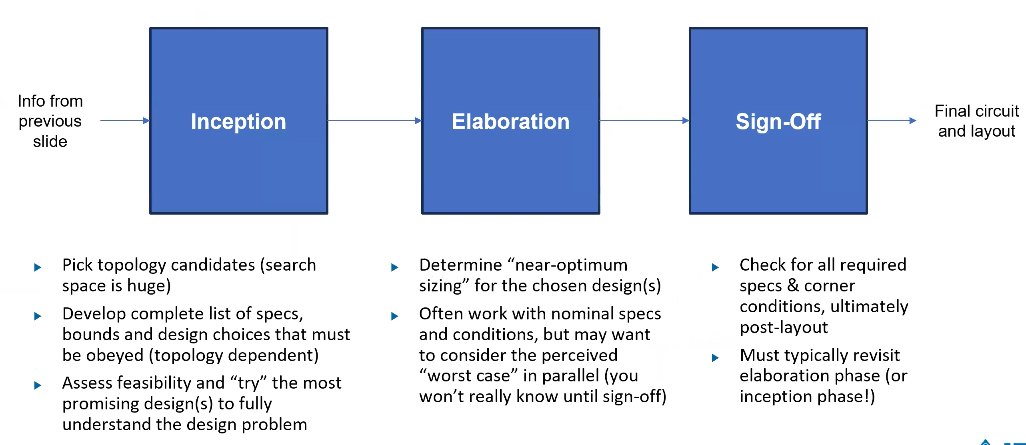

**Concepción** 

- Explorar candidatos de topología
- Desarrollar lista de especificaciones, limitaciones, decisiones de diseño, dependencias con las topologías.
- Determinar la factibilidad. Validar con un diseño inicial, idealmente preexistente.

Algunos amplificadores deben considerar el ruido de suministro, por lo que se considera como una nueva especificación.

Esta etapa es de mucha creatividad, innovación y discusión con otros ingenieros.


**Elaboración**

- Se determinan dimensionamientos cercanos a lo óptimo con especificaciones nominales. Pueden ocuparse herramientas de automatización de alguna etapa interna.
- Se consideran los peores casos de la etapa siguiente, pero no se conocen hasta el sign-off.

**Sign-Off**

- Verificar especificaciones ante simulaciones de corners y post-layout
- Entornos industriales pueden tener cientos de corners, el crecimiento de los corners es geométrico.

### Flujo de diseño del profesor Boris Murmann

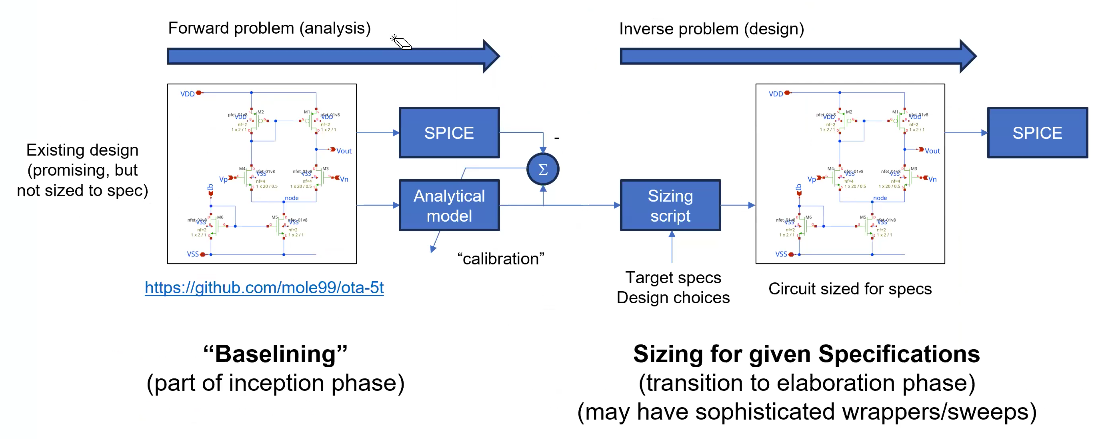

Se divide el trabajo de diseño en dos etapas que permitirán entender y diseñar el sistema.

**Baselining**: Análisis de un circuito

Luego de seleccionar una topología que aparente ser útil en el problema asignado, toca analizarlo sin restringirse a los requerimientos específicos.

Por medio de simulación, se busca obtener un conjunto de métricas relevantes verificables. 
Sumado a esto, se debe desarrollar un modelo analítico que permita predecir especificaciones según las características de los transistores y el sistema en conjunto.

Es importante comparar el modelo analítico con las simulaciones y calibrar correctamente. 
Como resultado, se tendrá una manera de simular el circuito, y calcular sus especificaciones.

Esta etapa es parte de la etapa de concepción.

**Sizing for spec**

Con el modelo analítico se elabora una estrategia de dimensionamiento de los transistores con tal de cumplir las especificaciones dadas.

## Análisis baseline OTA 5T

En base al modelo analítico, se busca ser capaz de predecir las especificaciones de acuerdo al dimensionamiento de los transistores.
No se necesita un dimensionamiento acorde al problema, solo que la predicción sea similar al valor obtenido por simulación.

In [2]:
system: System = {
    "T": 300,
    "CL": 1e-12,
    "Ib": 10e-6,  # Current
}

fets: Fets = {
    "M0": {
        "type": nfet_lvt,
        "l": 1.0,
        "w": 2.0,
        "nf": 2,
        "vds": 0.3,
        "vsb": 0.0,
    },
    "M1": {
        "type": nfet_lvt,
        "l": 0.5,
        "w": 20.0,
        "nf": 4,
        "vds": 0.3,
        "vsb": 0.0,
    },
    "M2": {
        "type": pfet,
        "l": 1.0,
        "w": 2.0,
        "nf": 2,
        "vds": 0.9,
        "vsb": 0.0,
    },
}


def ota_5t_fill_fets(system: System, fets: Fets) -> Fets:
    """Augment "fets" with LUT information"""
    fets = deepcopy(fets)

    fets["M0"]["id"] = system["Ib"]
    fets["M1"]["id"] = system["Ib"] / 2
    fets["M2"]["id"] = system["Ib"] / 2

    for fet in fets.values():
        params = {
            "ID_W": fet["id"] / fet["w"],
            "L": fet["l"],
            "VDS": fet["vds"],
            "VSB": fet["vsb"],
        }

        fet["gm_id"] = fet["type"].lookup("GM_ID", **params)
        fet["gm_cgg"] = fet["type"].lookup("GM_CGG", **params)
        fet["gm_cdd"] = fet["type"].lookup("GM_CDD", **params)
        fet["gm_cgd"] = fet["type"].lookup("GM_CGD", **params)
        fet["gm_gds"] = fet["type"].lookup("GM_GDS", **params)
        fet["sth_gm"] = fet["type"].lookup("STH_GM", **params)

        fet["gm"] = fet["id"] * fet["gm_id"]
        fet["gds"] = fet["gm"] / fet["gm_gds"]
        fet["cgg"] = fet["gm"] / fet["gm_cgg"]
        fet["cdd"] = fet["gm"] / fet["gm_cgg"]
        fet["cgd"] = fet["gm"] / fet["gm_cgd"]
        fet["ft"] = fet["gm_cgg"] / (2 * np.pi)
        fet["gamma"] = fet["sth_gm"] / (4 * kB * system["T"])

    return fets


def ota_5t_adjust_fets_magnitudes(fets: Fets) -> pd.DataFrame:
    """Return a dataframe with suitable magnitudes"""
    df = pd.DataFrame()

    for name, fet in fets.items():
        df[name] = pd.Series(
            {
                "gm_id (S/A)": fet["gm_id"],
                "gm_gds": fet["gm_gds"],
                "gm_cgg": fet["gm_cgg"],
                "gm (uS)": fet["gm"] / 1e-6,
                "gds (uS)": fet["gds"] / 1e-6,
                "cgg (fF)": fet["cgg"] / 1e-15,
                "cdd (fF)": fet["cdd"] / 1e-15,
                "cgd (fF)": fet["cgd"] / 1e-15,
                "ft (GHz)": fet["ft"] / 1e9,
                "gamma": fet["gamma"],
            }
        )

    return df.round(2)


ota_5t_adjust_fets_magnitudes(ota_5t_fill_fets(system, fets))

,M0,M1,M2
gm_id (S/A),9.420727815781252,22.981437071720162,7.180361698064486
gm_gds,34.56165295436726,57.54110358563184,253.36584997867834
gm_cgg,7965099737.319248,2242415332.5624804,3292654839.1987195
gm (uS),94.207278,114.907185,35.901808
gds (uS),2.725775,1.996958,0.141699
cgg (fF),11.827508,51.242597,10.903605
cdd (fF),11.827508,51.242597,10.903605
cgd (fF),0.813796,5.003699,0.109069
ft (GHz),1.267685,0.356891,0.524042
gamma,1.857571,1.300241,1.149072


La función `get_system_specs` ocupa el modelo analítico para generar predicciones de las especificaciones del circuito.

In [3]:
def ota_5t_get_system_specs(system: System, fets: Fets) -> System:
    # Avoid modifying original "system"
    system = deepcopy(system)

    M1 = fets["M1"]
    M2 = fets["M2"]

    # Intrinsic Gain
    system["A0"] = M1["gm"] / (M1["gds"] + M2["gds"])

    # UGF
    cltot = system["CL"] + M1["cdd"] + M2["cdd"]
    system["UGF"] = M1["gm"] / (cltot * 2 * np.pi)

    # PM
    system["fp2"] = M2["gm_cgg"] / (2 * np.pi)
    system["fz2"] = 2 * system["fp2"]
    system["fz3"] = M1["gm"] / (M1["cgd"] * 2 * np.pi)
    system["phip2"] = -np.arctan(system["UGF"] / system["fp2"]) * 180 / np.pi
    system["phiz2"] = +np.arctan(system["UGF"] / system["fz2"]) * 180 / np.pi
    system["phiz3"] = -np.arctan(system["UGF"] / system["fz3"]) * 180 / np.pi
    system["PM"] = 90 + system["phip2"] + system["phiz2"] + system["phiz3"]

    # NOI
    system["NOI"] = (
        M1["gamma"] * (1 + 2 * M2["gamma"] / M1["gamma"]) * kB * system["T"] / cltot
    ) ** 0.5

    return system


def ota_5t_adjust_system_magnitudes(system: System) -> pd.DataFrame:
    return pd.DataFrame(
        {
            "ota_5t": {
                "A0": system["A0"],
                "UGF (MHz)": system["UGF"] / 1e6,
                "PM (deg)": system["PM"],
                "Noise (uVrms)": system["NOI"] / 1e-6,
                "fp2 (MHz)": system["fp2"] / 1e6,
                "fz2 (MHz)": system["fz2"] / 1e6,
                "fz3 (MHz)": system["fz3"] / 1e6,
                "phip2 (deg)": system["phip2"],
                "phiz2 (deg)": system["phiz2"],
                "phiz3 (deg)": system["phiz3"],
            }
        }
    ).round(2)


filled_fets = ota_5t_fill_fets(system, fets)
system_specs = ota_5t_get_system_specs(system, filled_fets)

display(ota_5t_adjust_fets_magnitudes(filled_fets))
display(ota_5t_adjust_system_magnitudes(system_specs))

,M0,M1,M2
gm_id (S/A),9.420727815781252,22.981437071720162,7.180361698064486
gm_gds,34.56165295436726,57.54110358563184,253.36584997867834
gm_cgg,7965099737.319248,2242415332.5624804,3292654839.1987195
gm (uS),94.207278,114.907185,35.901808
gds (uS),2.725775,1.996958,0.141699
cgg (fF),11.827508,51.242597,10.903605
cdd (fF),11.827508,51.242597,10.903605
cgd (fF),0.813796,5.003699,0.109069
ft (GHz),1.267685,0.356891,0.524042
gamma,1.857571,1.300241,1.149072


,ota_5t
A0,53.73
UGF (MHz),17.22
PM (deg),88.79
Noise (uVrms),118.46
fp2 (MHz),524.04
fz2 (MHz),1048.08
fz3 (MHz),3654.91
phip2 (deg),-1.88
phiz2 (deg),0.94
phiz3 (deg),-0.27


El modelamiento analítico del circuito es contenido de los libros de microelectrónica, en este ejemplo los cálculos no son tan complicados pero pueden haber casos que requieran de algoritmos de optimización más elaborados.

Los valores entregados por ngspice se resumen en la siguiente tabla. No están muy alejados de los valores calculados, por lo que se puede validar el modelo

| Parámetro | Modelo Analítico | Ngspice |
|--|--|--|
| A0 | 53.73 | 50.208 |
| UGH | 17.22 | 17.141 |
| PM | 88.79| 87.41 |
| Noise | 118.46 | 114.15|

Como resultado del baselining, se tiene un modelo que a partir de una descripción del sistema y el dimensionamiento de los transistores permite obtener especificaciones técnicas. Con esta información se puede empezar la automatización de dimensionamiento.

### En resumen

In [4]:
system = {
    "T": 300,
    "CL": 1e-12,
    "Ib": 10e-6,
}

fets = {
    "M0": {
        "type": nfet_lvt,
        "l": 1.0,
        "w": 2.0,
        "nf": 2,
        "vds": 0.3,
        "vsb": 0.0,
    },
    "M1": {
        "type": nfet_lvt,
        "l": 0.5,
        "w": 20.0,
        "nf": 4,
        "vds": 0.3,
        "vsb": 0.0,
    },
    "M2": {
        "type": pfet,
        "l": 1.0,
        "w": 2.0,
        "nf": 2,
        "vds": 0.9,
        "vsb": 0.0,
    },
}

filled_fets = ota_5t_fill_fets(system, fets)
estimated_system = ota_5t_get_system_specs(system, filled_fets)

display(ota_5t_adjust_fets_magnitudes(filled_fets))
display(ota_5t_adjust_system_magnitudes(estimated_system))

,M0,M1,M2
gm_id (S/A),9.420727815781252,22.981437071720162,7.180361698064486
gm_gds,34.56165295436726,57.54110358563184,253.36584997867834
gm_cgg,7965099737.319248,2242415332.5624804,3292654839.1987195
gm (uS),94.207278,114.907185,35.901808
gds (uS),2.725775,1.996958,0.141699
cgg (fF),11.827508,51.242597,10.903605
cdd (fF),11.827508,51.242597,10.903605
cgd (fF),0.813796,5.003699,0.109069
ft (GHz),1.267685,0.356891,0.524042
gamma,1.857571,1.300241,1.149072


,ota_5t
A0,53.73
UGF (MHz),17.22
PM (deg),88.79
Noise (uVrms),118.46
fp2 (MHz),524.04
fz2 (MHz),1048.08
fz3 (MHz),3654.91
phip2 (deg),-1.88
phiz2 (deg),0.94
phiz3 (deg),-0.27


### Problemas en transistores

En los pfets, la ganancia intrínseca incrementa demasiado con el largo. Un largo de 3 um no va a generar una ganancia de 1000 V/V.

Para el diseño con pmos, existen las siguientes restricciones:

- Ocupar valores de largo que estén por bajo 0.6 ~ 0.7 um
- Operar en inversión fuerte

**Estos problemas ocurren con el modelo `pfet_lvt`?**

No, el modelo `pfet_lvt` puede ocuparse con la restricción que L mínimo debe ser 0.35 um.

## Dimensionamiento de la OTA

Lograr el baselining es usualmente sencillo

- Bastante documentación al respecto
- Mapear de W/L a especificaciones técnicas como ganancias, anchos de banda, etc.

El dimensionamiento requiere de ir al revés, a partir de las especificaciones llegar al W/L

- Invertir ecuaciones no siempre es posible
- Ecuaciones pueden estar conectadas entre si.

Hay 2 estrategias principales:

**Forward Evaluation**

Se evalúa y explora el espacio solución de manera numérica.
Dado que aún se basa en el modelo analítico, es rápido y permite visualizar varios aspectos del comportamiento del circuito.

**Knowledge-based design**

Insistir en la inversión de las ecuaciones. Es el método utilizado por Boris Murmann.
Además del uso del modelo, requiere un conocimiento profundo sobre el circuito y las consecuencias de las elecciones de diseño.

Para el caso de esta OTA, el procedimiento es el siguiente:

1. Escoger un largo de acuerdo a la especificación de ganancia lazo abierto
    - Ajusta el polo no dominante
    - Si el ancho no es suficientemente largo, nada funcionará.
1. Calcular capacitancia de carga $C_L$ según el ruido
    - Necesario para determinar $g_m$
1. Computar máximo UGF según polo no dominante y especificación de margen de fase
    - Con esto se obtiene $g_m$

La selección de $g_m/I_D$ por cada transistor es una elección arbitraria, determinada por las elecciones que el diseñador escoja.

- Se considera eficiencia en transistores M1. $g_m/I_D=20(S/A)$
- Transitores M2 del espejo con baja eficiencia pero menor ruido y mayor polo no dominante. $g_m/I_D=10(S/A)$

In [5]:
system = {"T": 300, "A0": 30, "PM": 80, "NOI": 50e-6}

gm_id = 20
gm2_gm1 = 0.5

fets = {
    "M0": {"type": nfet_lvt, "gm_id": gm_id, "vds": 0.3, "vsb": 0.0},
    "M1": {"type": nfet_lvt, "gm_id": gm_id, "vds": 0.3, "vsb": 0.0},
    "M2": {"type": pfet, "gm_id": gm2_gm1 * gm_id, "vds": 0.9, "vsb": 0.0},
}

display(system)
display(fets)

{'T': 300, 'A0': 30, 'PM': 80, 'NOI': 5e-05}

{'M0': {'type': <pygmid.Lookup.Lookup at 0x7fc2a5c03700>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0},
 'M1': {'type': <pygmid.Lookup.Lookup at 0x7fc2a5c03700>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0},
 'M2': {'type': <pygmid.Lookup.Lookup at 0x7fc2a5c037f0>,
  'gm_id': 10.0,
  'vds': 0.9,
  'vsb': 0.0}}

### Encontrar el largo mínimo que satisfaga requisito de ganancia.

**Criterios**: 

- El modelo pfet es malo. Se ocupará el mismo L que para el nfet con algo de margen
- $A_0 = M1_{gm} / (M1_{gds} + M2_{gds})$

In [6]:
def ota_5t_find_L(system: System, fets: Fets) -> Fets:
    fets = deepcopy(fets)
    M1 = fets["M1"]

    for l in M1["type"]["L"]:
        gm_gds = M1["type"].lookup("GM_GDS", GM_ID=M1["gm_id"], L=l, VDS=M1["vds"])

        if gm_gds > 2 * system["A0"]:
            break

    fets["M0"]["l"] = l
    fets["M1"]["l"] = l
    fets["M2"]["l"] = l

    return fets


fets = ota_5t_find_L(system, fets)
fets

{'M0': {'type': <pygmid.Lookup.Lookup at 0x7fc260d7e8c0>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0,
  'l': 0.6},
 'M1': {'type': <pygmid.Lookup.Lookup at 0x7fc260d7e8c0>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0,
  'l': 0.6},
 'M2': {'type': <pygmid.Lookup.Lookup at 0x7fc2a5c03ac0>,
  'gm_id': 10.0,
  'vds': 0.9,
  'vsb': 0.0,
  'l': 0.6}}

### Calcular la capacitancia de carga

Criterios:

- Se ignoran capacitancias de los dispositivos, solo $C_L$
- Sobredimensionar pensando en ruido $1/f$
- $NOI = ( M1_{gamma} * ( 1 + 2 * M1_{gamma} * M2_{gamma}) * k_B * T / C_L)^{0.5}$

In [7]:
def ota_5t_find_cl(system: System, fets: Fets, margin=1.2) -> System:
    system = deepcopy(system)

    M1 = fets["M1"]
    M2 = fets["M2"]

    M1_sth_gm = M1["type"].lookup("STH_GM", GM_ID=M1["gm_id"], L=M1["l"])
    M2_sth_gm = M2["type"].lookup("STH_GM", GM_ID=M2["gm_id"], L=M2["l"])

    M1_gamma = M1_sth_gm / (4 * kB * system["T"])
    M2_gamma = M2_sth_gm / (4 * kB * system["T"])

    system["CL"] = (
        margin
        * M1_gamma
        * (1 + 2 * M2_gamma / M1_gamma)
        * kB
        * system["T"]
        / system["NOI"] ** 2
    )

    return system


system = ota_5t_find_cl(system, fets)
system

{'T': 300, 'A0': 30, 'PM': 80, 'NOI': 5e-05, 'CL': 7.017446665694912e-12}

### Cálculo de frecuencia polo no dominante y UGF

Criterio:

- Asegurar margen de fase
- me margin, as it neglects the LHP zero that returns some of the phase
- $phi = arctan( \frac {UGF} {fp2}) * 180/pi$

In [8]:
def ota_5t_find_UGF(system: System, fets: Fets) -> System:
    system = deepcopy(system)

    M2 = fets["M2"]

    M2_gm_cgg = M2["type"].lookup("GM_CGG", GM_ID=M2["gm_id"], L=M2["l"])
    fp2 = 0.5 * M2_gm_cgg / (2 * np.pi)

    phi = 90 - system["PM"]
    fp2_UGF = 1 / np.tan(phi / (180 / np.pi))

    system["UGF"] = fp2 / fp2_UGF
    return system


system = ota_5t_find_UGF(system, fets)
system

{'T': 300,
 'A0': 30,
 'PM': 80,
 'NOI': 5e-05,
 'CL': 7.017446665694912e-12,
 'UGF': 83316286.62802024}

### Calcular M1_gm

Criterio:

- Cumplir con UGF
- Ignorar capacitancias de dispositivos, solo carga
- $UGF = M1_{gm} / ( C_L * 2 * np.pi)$

In [9]:
def ota_5t_find_M1_gm(system: System, fets: Fets) -> Fets:
    fets = deepcopy(fets)
    fets["M1"]["gm"] = system["UGF"] * system["CL"] * 2 * np.pi

    return fets


fets = ota_5t_find_M1_gm(system, fets)
fets

{'M0': {'type': <pygmid.Lookup.Lookup at 0x7fc260d7d450>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0,
  'l': 0.6},
 'M1': {'type': <pygmid.Lookup.Lookup at 0x7fc260d7d450>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0,
  'l': 0.6,
  'gm': 0.003673574860055071},
 'M2': {'type': <pygmid.Lookup.Lookup at 0x7fc2a5c03ee0>,
  'gm_id': 10.0,
  'vds': 0.9,
  'vsb': 0.0,
  'l': 0.6}}

### Calcular corriente de bias

In [10]:
def ota_5t_find_ib(system: System, fets: Fets) -> System:
    system = deepcopy(system)
    M1 = fets["M1"]

    system["Ib"] = 2 * M1["gm"] / M1["gm_id"]
    return system


system = ota_5t_find_ib(system, fets)
system

{'T': 300,
 'A0': 30,
 'PM': 80,
 'NOI': 5e-05,
 'CL': 7.017446665694912e-12,
 'UGF': 83316286.62802024,
 'Ib': 0.0003673574860055071}

In [11]:
def ota_5t_find_id(system: System, fets: Fets) -> Fets:
    fets = deepcopy(fets)

    fets["M0"]["id"] = system["Ib"]
    fets["M1"]["id"] = 0.5 * system["Ib"]
    fets["M2"]["id"] = 0.5 * system["Ib"]

    return fets


fets = ota_5t_find_id(system, fets)
fets

{'M0': {'type': <pygmid.Lookup.Lookup at 0x7fc260d7e4a0>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0,
  'l': 0.6,
  'id': 0.0003673574860055071},
 'M1': {'type': <pygmid.Lookup.Lookup at 0x7fc260d7e4a0>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0,
  'l': 0.6,
  'gm': 0.003673574860055071,
  'id': 0.00018367874300275356},
 'M2': {'type': <pygmid.Lookup.Lookup at 0x7fc2a5c03eb0>,
  'gm_id': 10.0,
  'vds': 0.9,
  'vsb': 0.0,
  'l': 0.6,
  'id': 0.00018367874300275356}}

In [12]:
def ota_5t_find_w_nf(system: System, fets: Fets) -> Fets:
    """Returns width and number of fingers according to gm/ID and ID for each fet
    This gives a fet sizing from which to get the specs again.
    """
    fets = deepcopy(fets)

    # Those values can be modified because this is a deep copy
    M0 = fets["M0"]
    M1 = fets["M1"]
    M2 = fets["M2"]

    M0["id_w"] = M0["type"].lookup("ID_W", GM_ID=M0["gm_id"], L=M0["l"])
    M1["id_w"] = M1["type"].lookup("ID_W", GM_ID=M1["gm_id"], L=M1["l"])
    M2["id_w"] = M2["type"].lookup("ID_W", GM_ID=M2["gm_id"], L=M2["l"])

    M0["w"] = M0["id"] / M0["id_w"]
    M1["w"] = M1["id"] / M1["id_w"]
    M2["w"] = M2["id"] / M2["id_w"]

    wfing = 5

    M0["nf"] = 1 + np.floor_divide(M0["w"], wfing)
    M1["nf"] = 1 + np.floor_divide(M1["w"], wfing)
    M2["nf"] = 1 + np.floor_divide(M2["w"], wfing)

    # Set W according to number of fingers
    M0["w"] = M0["nf"] * wfing
    M1["w"] = M1["nf"] * wfing
    M2["w"] = M2["nf"] * wfing

    return fets


fets = ota_5t_find_w_nf(system, fets)
fets

{'M0': {'type': <pygmid.Lookup.Lookup at 0x7fc260d8a7d0>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0,
  'l': 0.6,
  'id': 0.0003673574860055071,
  'id_w': array(7.56478238e-07),
  'w': 490.0,
  'nf': 98.0},
 'M1': {'type': <pygmid.Lookup.Lookup at 0x7fc260d8a7d0>,
  'gm_id': 20,
  'vds': 0.3,
  'vsb': 0.0,
  'l': 0.6,
  'gm': 0.003673574860055071,
  'id': 0.00018367874300275356,
  'id_w': array(7.56478238e-07),
  'w': 245.0,
  'nf': 49.0},
 'M2': {'type': <pygmid.Lookup.Lookup at 0x7fc260d8a920>,
  'gm_id': 10.0,
  'vds': 0.9,
  'vsb': 0.0,
  'l': 0.6,
  'id': 0.00018367874300275356,
  'id_w': array(1.90533652e-06),
  'w': 100.0,
  'nf': 20.0}}

### En Conclusión

Teniendo las funciones de dimensionamiento, se puede agrupar todo lo desarrollado para obtener los W/L de cada transistor, y ocupar la funcion de baseline para estimar el rendimiento del circuito.

In [13]:
def ota_sizing(system: System, fets: Fets) -> tuple[System, Fets]:
    system = deepcopy(system)
    fets = deepcopy(fets)

    fets = ota_5t_find_L(system, fets)
    system = ota_5t_find_cl(system, fets, margin=1.2)
    system = ota_5t_find_UGF(system, fets)
    fets = ota_5t_find_M1_gm(system, fets)
    system = ota_5t_find_ib(system, fets)
    fets = ota_5t_find_id(system, fets)
    fets = ota_5t_find_w_nf(system, fets)

    return system, fets

In [14]:
system = {"T": 300, "A0": 30, "PM": 80, "NOI": 50e-6}

gm_id = 20
gm2_gm1 = 0.5

fets = {
    "M0": {"type": nfet_lvt, "gm_id": gm_id, "vds": 0.3, "vsb": 0.0},
    "M1": {"type": nfet_lvt, "gm_id": gm_id, "vds": 0.3, "vsb": 0.0},
    "M2": {"type": pfet, "gm_id": gm2_gm1 * gm_id, "vds": 0.9, "vsb": 0.0},
}

system, fets = ota_sizing(system, fets)

filled_fets = ota_5t_fill_fets(system, fets)
system_specs = ota_5t_get_system_specs(system, filled_fets)

display(ota_5t_adjust_fets_magnitudes(filled_fets))
display(ota_5t_adjust_system_magnitudes(system_specs))

,M0,M1,M2
gm_id (S/A),20.195607189280025,20.195607189280025,10.14140272462625
gm_gds,61.524254821650715,61.524254821650715,159.41892052921588
gm_cgg,4694188280.519838,4694188280.519838,5822802007.120001
gm (uS),7419.007485,3709.503743,1862.760105
gds (uS),120.58671,60.293355,11.684686
cgg (fF),1580.466535,790.233267,319.907856
cdd (fF),1580.466535,790.233267,319.907856
cgd (fF),127.825255,63.912627,4.919111
ft (GHz),0.747103,0.747103,0.926728
gamma,1.521804,1.521804,1.026361


,ota_5t
A0,51.54
UGF (MHz),72.64
PM (deg),87.31
Noise (uVrms),42.68
fp2 (MHz),926.73
fz2 (MHz),1853.46
fz3 (MHz),9237.39
phip2 (deg),-4.48
phiz2 (deg),2.24
phiz3 (deg),-0.45


## Etapa de Sign-Off

Una vez que el dimensionamiento tenga un comportamiento aceptable, se puede validar su funcionalidad en distintos corners, temperatura y variaciones en suministro para evaluar la robustez de la estimación.

Para realizar esta tarea se requiere de simulaciones spice. La herramienta `CACE` puede sistematizar la simulación y recolección de resultados de varias simulaciones, lo que simplifica el sign-off. También puede utilizarse en post-layout.

Creo que una idea que podría ser de utilidad en la etapa de elaboración, para obtener dimensionamientos más robustos es el uso de tablas obtenidas en distintos corners. Las funciones que obtienen los parámetros podrían calcular el peor caso para algún parámetro relevante, y dimensionar acorde a eso.

## Próximos Pasos

1. Especificar el dimensionamiento dentro de una simulación, integrar los resultados dentro del dataframe de las estimaciones
1. Ocupar GLayout para generar un gds, ocupar cace para validar sus especificaciones técnicas.